Two-stage choice model로 회귀하자

In [2]:
date = '250206'
dir_archive = 'sim_savefiles'

# Import Libraries

In [3]:
import numpy as np
from tqdm import tqdm
import random
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import easydict
from scipy.spatial.distance import euclidean
from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
from shapely.geometry import Point, MultiPolygon, Polygon
import geopandas as gpd
import openpyxl
from easydict import EasyDict
from tqdm import tqdm
from sklearn.neighbors import KDTree
from descartes import PolygonPatch
import matplotlib.colors as mcolors
from pyproj import Proj, transform
import seaborn as sns
import warnings
import pickle

# FutureWarning을 무시하도록 설정
warnings.filterwarnings("ignore", category=FutureWarning)

# 중부원점 좌표계 (TM 중부원점, EPSG:2097)
proj_tm_mid = Proj(init='epsg:2097')

# WGS84 좌표계 (EPSG:4326)
proj_wgs84 = Proj(init='epsg:4326')

plt.rcParams['font.family'] = 'AppleGothic'  # macOS에서 사용할 수 있는 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시 마이너스 기호 깨짐 방지

np.random.seed(42)
random.seed(4242)

/var/folders/jw/dc623yy10tl7kth41qt1v3b00000gn/T/ipykernel_51940/3453205633.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Functions

In [4]:
# pick random positions in given region
def random_points_in_multipolygon(shape, num_points):
    if isinstance(shape, Polygon):
        min_x, min_y, max_x, max_y = shape.bounds
    else:
        min_x, min_y, max_x, max_y = shape.geoms[0].bounds
        for i in range(1,len(shape.geoms)):
            polygon = shape.geoms[i]
            min_x_i, min_y_i, max_x_i, max_y_i = polygon.bounds
            if min_x_i<min_x:
                min_x = min_x_i
            if min_y_i<min_y:
                min_y = min_y_i
            if max_x_i>max_x:
                max_x = max_x_i
            if max_y_i>max_y:
                max_y = max_y_i
    # 좌표 설정
    points = []
    while len(points) < num_points:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if isinstance(shape, Polygon):
            if shape.contains(point):
                    points.append(point)
        else:
            for i in range(len(shape.geoms)):
                polygon = shape.geoms[i]
                if polygon.contains(point):
                    points.append(point)
            
    return points

In [5]:
def darken_color(color):
    darkened_color = (max(color[0] - 0.2,0), 
                      max(color[1] - 0.2,0),
                      max(color[2] - 0.2,0))
    return darkened_color

# Geographical Setting

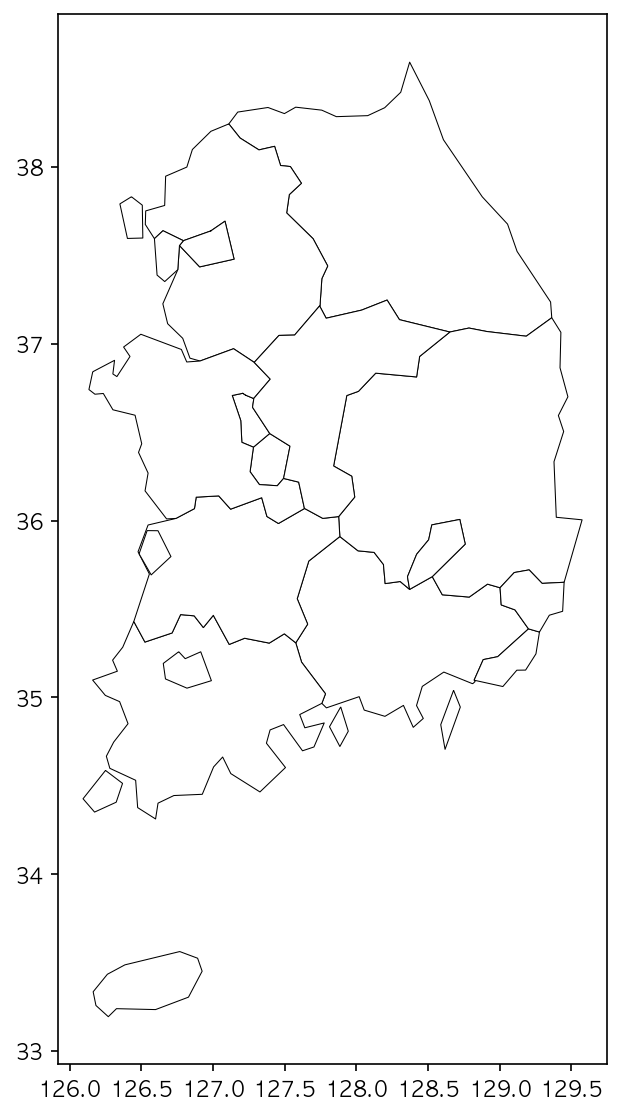

In [6]:
# shp 파일 로드
filepath_shp_simplified = '/Users/jungwoo/Library/Mobile Documents/com~apple~CloudDocs/Research Project/Assets/shapefiles_korea_simplified/TL_SCCO_CTPRVN/'
geo_file = 'TL_SCCO_CTPRVN.shp'
gdf = gpd.read_file(filepath_shp_simplified+geo_file, encoding='euc-kr')

gdf.CTP_KOR_NM = [
    '강원',
    '경기',
    '경남',
    '경북',
    '광주',
    '대구',
    '대전',
    '부산',
    '서울',
    '세종',
    '울산',
    '인천',
    '전남',
    '전북',
    '제주',
    '충남',
    '충북'
]

# 인천 고쳐주기
coords1 = [(126.59156455632241, 37.593011823985485), (126.6512526639701, 37.63798791865732),
           (126.79369544519706, 37.58159385885768), (126.7662043574505, 37.554242375748366),
           (126.7544652746883, 37.41757293948264), (126.66344966004381, 37.35053506629968),
           (126.60996708541704, 37.38718717658724), (126.59156455632241, 37.593011823985485)]
coords2 = [(126.43121685572747, 37.82986908194544), (126.35057985274231, 37.789565062650894),
           (126.40316813158975, 37.59428252797514), (126.51062866491168, 37.59662373953827),
           (126.5068975008081, 37.78234762310096), (126.43121685572747, 37.82986908194544)]
polygon1 = Polygon(coords1)
polygon2 = Polygon(coords2)
gdf.loc[11,'geometry'] = MultiPolygon([polygon1, polygon2])

# 충남 고쳐주기
coords1 = [(126.16122307201523, 36.84077447960923), (126.1346055789919, 36.740324711760486),
           (126.17654567314271, 36.71395826078249), (126.23492459115923, 36.71807007755431),
           (126.30206037378963, 36.62590094644257), (126.45646406403513, 36.595210697608685),
           (126.50292188756616, 36.43400816610959), (126.48058601093365, 36.38503110228303),
           (126.54732360572413, 36.2683451886003), (126.52610700099113, 36.167672899104176),
           (126.67649645277267, 36.00923289097959), (126.74156052854424, 36.0119448809583),
           (126.87081796412734, 36.06740464723523), (126.88282411119397, 36.13207402130215),
           (127.04003005195446, 36.13933847885477), (127.12318778724037, 36.06424768168607),
           (127.34009324309051, 36.128979280260644), (127.37649530932696, 36.02288908915842),
           (127.45674606514737, 35.983276216973415), (127.63829543249358, 36.06793987054469),
           (127.63791587136105, 36.06890166403231), (127.59802031438574, 36.21708890108369),
           (127.49257720191125, 36.23795395068193), (127.44871641082584, 36.19672289194393),
           (127.32394583489626, 36.203158372814976), (127.25877186484053, 36.2760505815688),
           (127.28212428234082, 36.414603964631645), (127.20138964906599, 36.44197527604719),
           (127.19378772255222, 36.564812513911036), (127.13437853561463, 36.7067919896922),
           (127.20793603234716, 36.71918904581354), (127.20792754283481, 36.71917583461923),
           (127.20792684751393, 36.71917607776152), (127.20787710929177, 36.71918850565105),
           (127.2078769797854, 36.71919046333673), (127.20787710929177, 36.71918850565105),
           (127.20792754283481, 36.71917583461923), (127.20789089293503, 36.719119287386114),
           (127.22822551880574, 36.708468998779054), (127.22822008391248, 36.70845514952263),
           (127.22822551880574, 36.708468998779054), (127.22823057936279, 36.70846556314337),
           (127.28126367067202, 36.69057059579415), (127.28125389722467, 36.69051337150437),
           (127.28126367067202, 36.69057059579415), (127.28127028658162, 36.69055905464245),
           (127.28529006643944, 36.690671454249056), (127.39951636598008, 36.7992190104284),
           (127.28782886465115, 36.893778879374906), (127.14366362142856, 36.97105116272797),
           (126.90970519398604, 36.90160135376443), (126.8169656460083, 36.8961446522021),
           (126.77958940321619, 36.96680085646616), (126.49675135100698, 37.052811981614845),
           (126.37649095830157, 36.9806341203674), (126.42112642747156, 36.92727201106454),
           (126.32973391103106, 36.81358358482278), (126.30162178982232, 36.82841928228409),
           (126.31328915259776, 36.90549865703278), (126.16122307201523, 36.84077447960923)]
gdf.loc[15,'geometry'] = Polygon(coords1)

# GeoDataFrame 플롯
fig, ax = plt.subplots(figsize=(10, 7), 
                           gridspec_kw={'left': 0, 'right': 1, 'bottom': 0, 'top': 1}, 
                           dpi=150)

# for idx,row in gdf.iterrows():
#     print(isinstance(row.geometry, Polygon))

gdf.plot(ax=ax, color='w', linewidth=0.5, edgecolor='black', alpha=1)
# ax.axis('off')
plt.show()

### Mask Setting

In [7]:
gdf

,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry
0,42,Gangwon-do,강원,"POLYGON ((129.36340 37.14600, 129.18541 37.041..."
1,41,Gyeonggi-do,경기,"POLYGON ((127.11055 38.24157, 127.18893 38.161..."
2,48,Gyeongsangnam-do,경남,"MULTIPOLYGON (((127.89107 34.94678, 127.81288 ..."
3,47,Gyeongsangbuk-do,경북,"POLYGON ((129.44963 35.65102, 129.29626 35.644..."
4,29,Gwangju,광주,"POLYGON ((126.76105 35.25857, 126.80622 35.219..."
5,27,Daegu,대구,"POLYGON ((128.52985 35.68302, 128.37175 35.610..."
6,30,Daejeon,대전,"POLYGON ((127.49258 36.23795, 127.44872 36.196..."
7,26,Busan,부산,"POLYGON ((128.82172 35.09774, 129.02229 35.061..."
8,11,Seoul,서울,"POLYGON ((126.76620 37.55424, 126.79370 37.581..."
9,36,Sejong-si,세종,"POLYGON ((127.20794 36.71919, 127.20793 36.719..."


In [8]:
all_polygons = []
# 각 행의 geometry를 반복하여 처리합니다.
for geom in gdf['geometry']:
    # 다중 다각형인 경우,
    if geom.geom_type == 'MultiPolygon':
        # 다중 다각형을 이루는 각각의 단일 다각형을 리스트에 추가합니다.
        for single_polygon in geom.geoms:
            all_polygons.append(single_polygon)
    # 일반 다각형인 경우,
    elif geom.geom_type == 'Polygon':
        # 리스트에 바로 추가합니다.
        all_polygons.append(geom)


grid_resolution = 1000

min_x = min(polygon.bounds[0] for polygon in all_polygons)
max_x = max(polygon.bounds[2] for polygon in all_polygons)
min_y = min(polygon.bounds[1] for polygon in all_polygons)
max_y = max(polygon.bounds[3] for polygon in all_polygons)

xi = np.linspace(min_x, max_x, grid_resolution)
yi = np.linspace(min_y, max_y, grid_resolution)
xi, yi = np.meshgrid(xi, yi)

polygon_points = [(x_val, y_val) for x_val, y_val in zip(xi.flatten(), yi.flatten())]

In [9]:
# # 배열 계산하고 저장

# inside_polygon_mask_2d = np.array([[all_polygons[i].contains(Point(x_val, y_val)) for x_val, y_val in polygon_points] for i in range(len(all_polygons))])
# outside_polygon_mask = np.where(np.sum(inside_polygon_mask_2d, axis=0)==0)[0]

# file_path = "Outmigration_SIM_Data/240426/outside_polygon_mask.npy"
# np.save(file_path, outside_polygon_mask)

In [10]:
# 배열 읽어와서 활용

file_path = "/Users/jungwoo/Library/Mobile Documents/com~apple~CloudDocs/Research Project/서울대학교 의과대학 연구협업/Outmigration_SIM_Data/240426/outside_polygon_mask.npy"
outside_polygon_mask = np.load(file_path)

# Class codes

## Class Simulation

In [11]:
class Simulation:
    def __init__(self, parameter_set):
        self.parameter_set = parameter_set
        self.df_parameter = parameter_set.df_parameter
        self.df_hospital_crd = parameter_set.df_hospital_crd

        self.num_population = sum(self.parameter_set.df_parameter[self.parameter_set.target_population_column])
        self.num_hospital = sum(self.parameter_set.df_parameter['NUM_HOSPITAL'])

        # Create arr_population_PHQ
        self.arr_population_PHQ = np.full((self.num_population,self.num_hospital), -1.0)
        # Create arr_population_PRQ
        self.arr_population_PRQ = np.full((self.num_population,len(self.parameter_set.dict_parameter_initial_PRQ)), -1.0)
        # Create arr_population_CancerOrNot
        self.arr_population_CancerOrNot = np.full(self.num_population, True)

        self.max_quality = parameter_set.max_quality
        self.min_quality = parameter_set.min_quality

# 각 에이전트를 생성하고 Neighbor까지 계산하기
    def initialize(self):
        # 도시 만들기
        self.create_Cities()
        # 병원 만들기
        self.create_Hospitals()
        # 사람 만들기
        self.create_People()
        # 각 사람의 Neighbor(Interaction 상대) 설정
        self.set_person_neighbors()

# Initial OQ, PQ 등을 설정하고 시뮬레이션 실행
    def execute(self):
        # 각 병원의 Objective Quality 설정
        self.set_OHQ()
        # 각 사람의 Initial Perceived Quality 설정
        self.set_person_initial_perception()
        # Archive 생성
        self.create_Archive()

        # Simulate!
        self.run_simulation()


# Create Agents

    # 도시 만들기
    def create_Cities(self):
        self.arr_City_NM = self.df_parameter.SIDO_NM.values
        self.arr_City = np.array([])    # 객체가 저장된 array

        for idx_city in range(len(self.arr_City_NM)):
            nm_city = self.arr_City_NM[idx_city]
            df_city_parameter = self.df_parameter.loc[self.df_parameter.SIDO_NM == nm_city]
            parameter_set_city = EasyDict({
                'idx_city' : idx_city,
                'nm_city' : nm_city,

                'population_real' : df_city_parameter.POPULATION_REAL.values[0],
                'num_population' : df_city_parameter[self.parameter_set.target_population_column].values[0],
                'num_hospital' : df_city_parameter.NUM_HOSPITAL.values[0],
                'nm_region' : df_city_parameter.REGION.values[0],

                'ratio_cancer' : self.parameter_set.ratio_cancer
                })
            self.arr_City = np.append(self.arr_City, City(parameter_set_city))
    
    # 병원 만들기
    def create_Hospitals(self):
        self.arr_Hospital = np.array([])     # 객체가 저장된 array
        # 정보가 저장된 dataframe
        self.df_Hospital_info = pd.DataFrame({'idx_hospital' : range(self.df_parameter.NUM_HOSPITAL.sum())})
        self.df_Hospital_info['nm_city'] = ''
        self.df_Hospital_info['idx_city'] = 0
        self.df_Hospital_info['coord'] = Point(0,0)
        self.df_Hospital_info['OQ_objective_quality'] = -1.0

        idx_hospital = 0
        self.idx_hospital_in_region = [[],[],[],[],[]]

        for idx_city in range(len(self.arr_City_NM)):
            nm_city = self.arr_City_NM[idx_city]
            # df_hospital_crd에 등록된 좌표 활용하기
            df_hospital_crd_city = self.df_hospital_crd.loc[self.df_hospital_crd.SIDO_NM == nm_city]
            arr_idx_hospital_incity = np.array([], dtype=int)

            for idx_hospital_incity in range(self.arr_City[idx_city].num_hospital):
                nm_hospital = df_hospital_crd_city.iloc[idx_hospital_incity].INST_NM
                hospital_crd = Point(transform(proj_tm_mid, proj_wgs84, 
                                              df_hospital_crd_city.iloc[idx_hospital_incity].loc['CRD_X'], 
                                              df_hospital_crd_city.iloc[idx_hospital_incity].loc['CRD_Y']))
                parameter_set_hospital = EasyDict({
                    'idx_hospital' : idx_hospital,
                    'nm_hospital' : nm_hospital,
                    'idx_city' : idx_city,
                    'nm_city' : nm_city,
                    'nm_hospital' : nm_hospital,
                    'coord' : hospital_crd
                    })
                self.arr_Hospital = np.append(self.arr_Hospital, Hospital(parameter_set_hospital))
                arr_idx_hospital_incity = np.append(arr_idx_hospital_incity, idx_hospital)

                self.df_Hospital_info.loc[idx_hospital, 'nm_hospital'] = nm_hospital
                self.df_Hospital_info.loc[idx_hospital, 'nm_city'] = nm_city
                self.df_Hospital_info.loc[idx_hospital, 'idx_city'] = idx_city
                self.df_Hospital_info.loc[idx_hospital, 'coord'] = hospital_crd
                idx_hospital += 1

            # 각 도시의 병원 idx 넣어주기
            self.arr_City[idx_city].arr_idx_hospital_incity = arr_idx_hospital_incity
        
        # df_Hospital_info에 지역정보 merge해놓기
        self.df_Hospital_info = pd.merge(self.df_Hospital_info, self.df_parameter[['SIDO_NM', 'REGION']], how='left', left_on = 'nm_city', right_on = 'SIDO_NM')
        region_mapping = {}
        for idx in range(len(self.parameter_set.dict_parameter_initial_PRQ)):
            region_mapping[list(self.parameter_set.dict_parameter_initial_PRQ.keys())[idx]] = idx
        self.df_Hospital_info['idx_REGION'] = self.df_Hospital_info['REGION'].map(region_mapping)

        for idx_REGION in range(len(region_mapping.keys())):
            self.idx_hospital_in_region[idx_REGION] = self.df_Hospital_info.loc[self.df_Hospital_info.idx_REGION == idx_REGION, 'idx_hospital'].values
    
    # 사람 만들기
    def create_People(self):
        self.arr_Person = np.array([])  # 객체가 저장된 array

        # 정보가 저장된 dataframe
        self.df_Person_info = pd.DataFrame({'idx_person' : range(self.df_parameter[self.parameter_set.target_population_column].sum())})
        self.df_Person_info['nm_city'] = ''
        self.df_Person_info['idx_city'] = 0
        self.df_Person_info['coord'] = Point(0,0)
        self.df_Person_info['is_cancerpatient'] = False
        self.df_Person_info['idx_chosen_hospital'] = -1
        self.df_Person_info['idx_region_chosen_hospital'] = -1

        # base PHQ 만들어두기
        self.set_base_PHQ()

        idx_person = 0

        for idx_city in range(len(self.arr_City_NM)):
            nm_city = self.arr_City_NM[idx_city]
            df_city_parameter = self.df_parameter.loc[self.df_parameter.SIDO_NM == nm_city]

            arr_idx_person_incity = np.array([], dtype=int)

            # 좌표 여러개 한번에 설정 (각 지역의 환자 수만큼)
            geom_city = gdf.loc[gdf.CTP_KOR_NM == nm_city].iloc[0].geometry
            random_coords = random_points_in_multipolygon(gdf.loc[gdf.CTP_KOR_NM == nm_city].iloc[0].geometry, self.arr_City[idx_city].num_population)
            
            # 환자 생성
            for idx_person_incity in range(self.arr_City[idx_city].num_population):
                parameter_set_person = EasyDict({                
                    'idx_person' : idx_person,
                    'is_cancerpatient' : True,
                    'is_new_cancerpatient' : True,
                    
                    'idx_city' : idx_city,
                    'nm_city' : nm_city,
                    'coord' : random_coords[idx_person_incity],
                    'dict_parameter_initial_PRQ' : self.parameter_set.dict_parameter_initial_PRQ,

                    'sd_noise_initial_OHQ' : self.parameter_set.sd_noise_initial_OHQ,
                    'sd_noise_initial_PHQ' : self.parameter_set.sd_noise_initial_PHQ,
                    'sd_noise_initial_PRQ' : self.parameter_set.sd_noise_initial_PRQ,

                    'list_coef_Susceptible' :   self.parameter_set.list_coef_Susceptible, # [PHQ, PRQ, Distance]
                    'list_coef_Cancer' :        self.parameter_set.list_coef_Cancer,      # [PHQ, PRQ, Distance]
                    
                    'df_Hospital_info' : self.df_Hospital_info,
                    'df_Person_info' : self.df_Person_info,
                    'idx_hospital_in_region' : self.idx_hospital_in_region,

                    'arr_population_PHQ' : self.arr_population_PHQ,
                    'arr_population_PRQ' : self.arr_population_PRQ,
                    'arr_population_CancerOrNot' : self.arr_population_CancerOrNot,

                    'base_PHQ' : self.base_PHQ
                    })
                
                # 암환자 다 만들면 비 암환자로 전환
                if idx_person_incity >= self.arr_City[idx_city].num_cancer_patient:
                    parameter_set_person['is_cancerpatient'] = False
                    parameter_set_person['is_new_cancerpatient'] = False
                    self.arr_population_CancerOrNot[idx_person] = False

                # self.arr_Person에 생성
                self.arr_Person = np.append(self.arr_Person, Person(parameter_set_person, self.parameter_set))
                # df_Person_info 업데이트
                arr_idx_person_incity = np.append(arr_idx_person_incity, idx_person)
                self.df_Person_info.loc[idx_person, 'nm_city'] = nm_city
                self.df_Person_info.loc[idx_person, 'idx_city'] = idx_city
                self.df_Person_info.loc[idx_person, 'coord'] = random_coords[idx_person_incity]
                self.df_Person_info.loc[idx_person, 'is_cancerpatient'] = parameter_set_person.is_cancerpatient
                idx_person += 1
            
            # 각 도시의 인구 idx 넣어주기
            self.arr_City[idx_city].arr_idx_person_incity = arr_idx_person_incity

        # Region merge
        self.df_Person_info = pd.merge(self.df_Person_info, 
                                       self.df_parameter[['SIDO_NM', 'REGION']],
                                       how='left', left_on = 'nm_city', right_on = 'SIDO_NM')


# Archive functions
    def create_Archive(self):
        self.achv_population_is_cancerpatient = np.full((self.parameter_set.max_dt, self.num_population), False)
        self.achv_population_is_cancerpatient[0] = self.df_Person_info.is_cancerpatient.values

        self.achv_population_choice_prob = np.full((self.parameter_set.max_dt, self.num_population, self.num_hospital), 0.0)
        self.achv_population_PRQ = np.full((self.parameter_set.max_dt, self.num_population, len(self.parameter_set.dict_parameter_initial_PRQ)), 0.0)
        self.achv_population_PHQ = np.full((self.parameter_set.max_dt, self.num_population, self.num_hospital), 0.0)
        self.achv_population_True_Utility = np.full((self.parameter_set.max_dt, self.num_population, self.num_hospital), 0.0)
        self.achv_OHQ = np.full((self.parameter_set.max_dt, self.num_hospital), 0.0)

        for idx_person in self.df_Person_info.idx_person.values:
            self.achv_population_choice_prob[0,idx_person] = self.arr_Person[idx_person].choice_prob
            self.achv_population_PRQ[0,idx_person] = self.arr_Person[idx_person].PRQ
            self.achv_population_PHQ[0,idx_person] = self.arr_Person[idx_person].PHQ
            self.achv_population_True_Utility[0, idx_person] = self.arr_Person[idx_person].arr_utility_hospital_true
        self.achv_OHQ[0] = self.df_Hospital_info.OQ_objective_quality.values


    def update_Archive(self, dt):
        self.achv_population_is_cancerpatient[dt] = self.df_Person_info.is_cancerpatient.values
        for idx_person in self.df_Person_info.idx_person.values:
            self.achv_population_choice_prob[dt,idx_person] = self.arr_Person[idx_person].choice_prob
            self.achv_population_PRQ[dt,idx_person] = self.arr_Person[idx_person].PRQ
            self.achv_population_PHQ[dt,idx_person] = self.arr_Person[idx_person].PHQ
            self.achv_population_True_Utility[dt, idx_person] = self.arr_Person[idx_person].arr_utility_hospital_true
        self.achv_OHQ[dt] = self.df_Hospital_info.OQ_objective_quality.values

# Initial Setting

    # 각 의료기관의 OQ는 Normal을 따르며, df_parameter에 OQ parameter가 들어있음
    def set_OHQ(self):
        for idx_hospital, row in self.df_Hospital_info.iterrows():
            nm_region = row['REGION']
            initial_OHQ = self.parameter_set.dict_parameter_initial_ORQ[nm_region] + np.random.normal(0, self.parameter_set.sd_noise_initial_OHQ)

            self.arr_Hospital[idx_hospital].OQ_obj_quality = initial_OHQ
            # df_Hospital_info에도 넣어줬음
            self.df_Hospital_info.loc[idx_hospital, 'OQ_objective_quality'] = initial_OHQ

    def set_person_initial_perception(self):
        # Calculate Initial PHQ, PRQ, distance effect
        for idx_person in self.df_Person_info.idx_person.values:

            # Calculate Initial PHQ for each hospital
            self.arr_Person[idx_person].calculate_initial_PHQ()
            self.arr_population_PHQ[idx_person,:] = self.arr_Person[idx_person].PHQ     # Update df_PHQ
            # Calculate Initial PRQ for each region
            self.arr_Person[idx_person].calculate_initial_PRQ()
            self.arr_population_PRQ[idx_person,:] = self.arr_Person[idx_person].PRQ     # Update df_PHQ
            

            # Calculate distance array to each hospitals
            self.arr_Person[idx_person].calculate_distance_effect()

            # Calculate utility to each hospitals
            self.arr_Person[idx_person].calculate_utility()
            # Calculate choice probability to each hospitals
            self.arr_Person[idx_person].calculate_choice_prob()

            # Cancer Patient choose their hospitals
            if self.arr_Person[idx_person].is_new_cancerpatient:
                self.arr_Person[idx_person].choose_hospital()

            self.arr_Person[idx_person].df_Person_info = self.df_Person_info


    # Interaction을 위한 neighbor 찾기
    def set_person_neighbors(self):
        coords_people = np.array([[point.x, point.y] for point in self.df_Person_info.coord.values])
        kdtree = KDTree(coords_people)
        nearest_neighbors_indices = kdtree.query(coords_people, k=max(self.parameter_set.num_neighbor_susceptible, 
                                                                      self.parameter_set.num_neighbor_cancer), 
                                                 return_distance=False)[:, 1:]

        for idx_person in range(len(self.arr_Person)):
            self.arr_Person[idx_person].list_idx_neighbor_susceptible = nearest_neighbors_indices[idx_person,:self.parameter_set.num_neighbor_susceptible]
            self.arr_Person[idx_person].list_dist_neighbor_susceptible = [self.df_Person_info.loc[idx_person].coord.distance(self.df_Person_info.loc[idx_neighbor].coord) for idx_neighbor in nearest_neighbors_indices[idx_person,:self.parameter_set.num_neighbor_susceptible]]
            self.arr_Person[idx_person].list_idx_neighbor_cancer = nearest_neighbors_indices[idx_person,:self.parameter_set.num_neighbor_cancer]
            self.arr_Person[idx_person].list_dist_neighbor_cancer = [self.df_Person_info.loc[idx_person].coord.distance(self.df_Person_info.loc[idx_neighbor].coord) for idx_neighbor in nearest_neighbors_indices[idx_person,:self.parameter_set.num_neighbor_cancer]]

    def set_base_PHQ(self):
        self.base_PHQ = np.zeros(len(self.df_Hospital_info))
        for region in self.parameter_set.dict_parameter_initial_PRQ.keys():
            self.base_PHQ[self.df_Hospital_info.loc[self.df_Hospital_info.REGION == region].index] = self.parameter_set.dict_parameter_initial_PRQ[region]

# 신규 암환자 생성
    def designate_new_cancerpatient(self):
        # idx_new_patient = np.random.choice(self.df_Person_info.loc[~self.df_Person_info.is_cancerpatient, 
        #                                  'idx_person'].values, 
        #                             size=self.parameter_set.new_patient_per_dt, 
        #                             replace=False)
        self.idx_new_patient = np.random.choice(self.df_Person_info['idx_person'].values, 
                                    size=self.parameter_set.new_patient_per_dt, 
                                    replace=False)
        for idx_person in self.idx_new_patient:
            self.arr_Person[idx_person].is_cancerpatient = True
            self.arr_Person[idx_person].is_new_cancerpatient = True
            self.arr_Person[idx_person].calculate_choice_prob()
            self.arr_Person[idx_person].choose_hospital()
            self.arr_population_CancerOrNot[idx_person] = True
        
        self.df_Person_info.loc[self.df_Person_info.idx_person.isin(self.idx_new_patient), 'is_cancerpatient'] = True
        



# 시뮬레이션 진행            
    def run_simulation(self):
        for dt in tqdm(range(1, self.parameter_set.max_dt)):

            # 새로운 암환자 생성
            self.designate_new_cancerpatient()

            # Information provision
            if self.parameter_set.prov_type > 0:
                self.provide_info(dt)
                for idx_person in range(len(self.arr_Person)):
                    self.arr_population_PHQ[idx_person] = self.arr_Person[idx_person].PHQ
                    self.arr_population_PRQ[idx_person] = self.arr_Person[idx_person].PRQ

            # 시뮬레이션 내 모든 사람의 quality update
            for idx_person in range(len(self.arr_Person)):
                # Hospital Quality Interaction
                self.arr_Person[idx_person].interaction_hospital_quality(dt)
                self.arr_population_PHQ[idx_person] = self.arr_Person[idx_person].PHQ
                # Regional Quality Interaction
                self.arr_Person[idx_person].interaction_regional_quality(dt)
                self.arr_population_PRQ[idx_person] = self.arr_Person[idx_person].PRQ
            
            # 시뮬레이션 내 모든 사람의 choice probability update
            for idx_person in range(len(self.arr_Person)):
                # Hospital Quality Interaction
                self.arr_Person[idx_person].calculate_choice_prob()

            # Choice Probability에 기반하여 VOR
            self.update_OHQ(dt)
            
            # Archive 업데이트
            self.update_Archive(dt)

            # if dt == 3:
            #     print("Over, day "+str(dt))
            #     break

# VOR
    def update_OHQ(self, dt):
        mean_hospital_choice_prob = np.mean(self.achv_population_choice_prob[dt-1], axis=0)
        delta_choice_prob = mean_hospital_choice_prob - np.mean(mean_hospital_choice_prob)
        boundary_smoothing_factor = np.abs(np.array([
                                    np.min((self.df_Hospital_info.OQ_objective_quality.values[i] - self.min_quality, 
                                        self.max_quality - self.df_Hospital_info.OQ_objective_quality.values[i]))
                                        for i in range(len(self.df_Hospital_info))])) / \
                                        (self.max_quality - self.min_quality) * 2 # (0~1)

        new_OHQ = (1 + delta_choice_prob * self.parameter_set.mu_VOR * boundary_smoothing_factor) * \
                    self.df_Hospital_info.OQ_objective_quality.values
        new_OHQ[np.where(new_OHQ>self.max_quality)] = self.max_quality
        new_OHQ[np.where(new_OHQ<self.min_quality)] = self.min_quality
        self.df_Hospital_info.OQ_objective_quality = new_OHQ

# Information Provision
    def provide_info(self, dt):
        # designate those who would be provided information consistently
        idx_susceptible = np.array(list(set(self.df_Person_info['idx_person'].values) - set(self.idx_new_patient)))
        idx_susceptible_info_prov = np.random.choice(idx_susceptible, 
                                                     size=int(np.round(len(idx_susceptible) * 
                                                                       self.parameter_set.ratio_prov_susceptible)), 
                                                                       replace=False)
        idx_patient_info_prov = np.random.choice(self.idx_new_patient,
                                                 size=int(np.round(len(self.idx_new_patient) * 
                                                                   self.parameter_set.ratio_prov_patient)),
                                                 replace=False)

        if self.parameter_set.prov_type == 1:
            temp_PRQ = self.df_Hospital_info.groupby('idx_REGION')['OQ_objective_quality'].mean().values
            for idx_person in np.concatenate((idx_susceptible_info_prov, idx_patient_info_prov)):
                self.arr_Person[idx_person].PRQ = np.random.normal(temp_PRQ, 
                                                    self.parameter_set.sd_noise_info_prov, 
                                                    len(temp_PRQ))

        if self.parameter_set.prov_type == 2:
            for idx_person in np.concatenate((idx_susceptible_info_prov, idx_patient_info_prov)):
                self.arr_Person[idx_person].PHQ = np.random.normal(self.achv_OHQ[dt-1], 
                                                    self.parameter_set.sd_noise_info_prov, 
                                                    len(self.df_Hospital_info))


## Class City

In [12]:
class City:
    def __init__(self, parameter_set):
        self.parameter_set = parameter_set
        self.idx = parameter_set.idx_city
        self.nm_region = parameter_set.nm_region
        self.nm = parameter_set.nm_city
        
        self.num_population_real = parameter_set.population_real
        self.num_population = parameter_set.num_population
        self.num_cancer_patient = round(self.num_population * parameter_set.ratio_cancer)
        self.num_cancer_susceptible = self.num_population - self.num_cancer_patient

        self.num_hospital = parameter_set.num_hospital

        self.coord_centroid = Point(0,0)

        self.arr_idx_person_incity = np.array([])
        self.arr_idx_hospital_incity = np.array([])

## Class Hospital

In [13]:
class Hospital:
    def __init__(self, parameter_set):
        self.parameter_set = parameter_set
        self.idx_city = -1
        self.nm_city = ""
        self.nm_hospital = ""

        self.OQ_obj_quality = 0
        
        self.coord = parameter_set.coord

## Class Person

In [21]:
class Person:
    def __init__(self, parameter_set, parameter_set_simulation):
        self.parameter_set = parameter_set
        self.parameter_set_simulation = parameter_set_simulation
        self.df_Hospital_info = parameter_set.df_Hospital_info
        self.df_Person_info = parameter_set.df_Person_info
        self.idx_hospital_in_region = parameter_set.idx_hospital_in_region

        # Personal info
        self.idx_person = parameter_set.idx_person
        self.is_cancerpatient = parameter_set.is_cancerpatient
        self.is_new_cancerpatient = parameter_set.is_new_cancerpatient
        self.idx_city = parameter_set.idx_city
        self.nm_city = parameter_set.nm_city
        self.coord = parameter_set.coord
        self.lambda_h_choice = self.parameter_set_simulation.lambda_h_choice

        # PHQ, PRQ
        self.dict_parameter_initial_PRQ = parameter_set.dict_parameter_initial_PRQ
        self.PHQ = np.array([])
        self.PRQ = np.array([])
        self.sd_noise_initial_PHQ = parameter_set.sd_noise_initial_PHQ
        self.sd_noise_initial_PRQ = parameter_set.sd_noise_initial_PRQ
        
        self.arr_population_PHQ = parameter_set.arr_population_PHQ
        self.arr_population_PRQ = parameter_set.arr_population_PRQ
        self.arr_population_CancerOrNot = parameter_set.arr_population_CancerOrNot

        self.max_quality = self.parameter_set_simulation.max_quality
        self.min_quality = self.parameter_set_simulation.min_quality

        # Distance effects
        self.arr_distance_to_hospital = np.array([])
        self.arr_distance_effect = np.array([])

        # Coefficients
        self.list_coef_Cancer = parameter_set.list_coef_Cancer              # [PHQ, PRQ, Distance]
        self.list_coef_Susceptible = parameter_set.list_coef_Susceptible    # [PHQ, PRQ, Distance]

        # Utility, Choice
        # self.Utility = np.zeros(len(self.df_Hospital_info))
        self.arr_utility_region = np.zeros(len(self.df_Hospital_info))
        self.arr_utility_hospital = np.zeros(len(self.df_Hospital_info))

        self.choice_prob = np.zeros(len(self.df_Hospital_info))
        self.idx_choice_hospital = -1   # 암환자가 되었을 때 고르는 의료기관

        # Interaction Target
        self.list_idx_neighbor = []
        
        # Interaction : Hospital Quality
        self.Q_h = np.full((self.parameter_set_simulation.max_dt,
                            len(self.df_Hospital_info)), -1.0)
        self.C_h = np.full((self.parameter_set_simulation.max_dt,
                            len(self.df_Hospital_info)), -1.0)
        self.S_h = np.full((self.parameter_set_simulation.max_dt,
                            len(self.df_Hospital_info)), -1.0)
        self.E_h = np.full((self.parameter_set_simulation.max_dt,
                            len(self.df_Hospital_info)), -1.0)
            # noise
        self.sd_noise_interaction_PHQ = self.parameter_set_simulation.sd_noise_interaction_PHQ
            # C : Direct Interaction from Cancer Patient
        self.mu_C_interaction_PHQ = self.parameter_set_simulation.mu_C_interaction_PHQ
        self.lambda_C_interaction_PHQ = self.parameter_set_simulation.lambda_C_interaction_PHQ
        self.k_C_interaction_PHQ = self.parameter_set_simulation.k_C_interaction_PHQ
            # S : Direct Interaction from Susceptible
        self.mu_S_interaction_PHQ = self.parameter_set_simulation.mu_S_interaction_PHQ
        self.lambda_S_interaction_PHQ = self.parameter_set_simulation.lambda_S_interaction_PHQ
        self.k_S_interaction_PHQ = self.parameter_set_simulation.k_S_interaction_PHQ
            # E : Experience based Realization
        self.mu_E_interaction_PHQ = self.parameter_set_simulation.mu_E_interaction_PHQ
        
        
        # Interaction : Regional Quality
        self.Q_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        self.C_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        self.S_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        self.N_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        self.U_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        self.E_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        
            # noise
        self.sd_noise_interaction_PRQ = self.parameter_set_simulation.sd_noise_interaction_PRQ
            # C : Direct Interaction from Cancer Patient
        self.mu_C_interaction_PRQ = self.parameter_set_simulation.mu_C_interaction_PRQ
        self.lambda_C_interaction_PRQ = self.parameter_set_simulation.lambda_C_interaction_PRQ
        self.k_C_interaction_PRQ = self.parameter_set_simulation.k_C_interaction_PRQ
            # S : Indirect Interaction from Susceptible
        self.mu_S_interaction_PRQ = self.parameter_set_simulation.mu_S_interaction_PRQ
        self.lambda_S_interaction_PRQ = self.parameter_set_simulation.lambda_S_interaction_PRQ
        self.k_S_interaction_PRQ = self.parameter_set_simulation.k_S_interaction_PRQ
            # N : Indirect Interaction from Region
        self.mu_N_interaction_PRQ = self.parameter_set_simulation.mu_N_interaction_PRQ
            # U : self Update of PRQ
        self.mu_U_interaction_PRQ = self.parameter_set_simulation.mu_U_interaction_PRQ
            # E : Experience based Realization on PRQ
        self.mu_E_interaction_PRQ = self.parameter_set_simulation.mu_E_interaction_PRQ

# Initial Hospital Quality
    def calculate_initial_PHQ(self):
        # # OHQ + personal noise
        # self.PHQ = (self.df_Hospital_info.OQ_objective_quality.values + 
        #                              np.random.normal(0, self.sd_noise_initial_PHQ, len(self.df_Hospital_info)))

        # PRQ + personal noise
        self.PHQ = (self.parameter_set.base_PHQ + 
                    np.random.normal(0, self.sd_noise_initial_PHQ, len(self.df_Hospital_info)))
        
        # MinMax Limit
        self.PHQ[np.where(self.PHQ>self.max_quality)] = self.max_quality
        self.PHQ[np.where(self.PHQ<self.min_quality)] = self.min_quality
        self.Q_h[0] = self.PHQ

# Initial Regional Quality
    def calculate_initial_PRQ(self):
        self.PRQ = np.array(list(self.dict_parameter_initial_PRQ.values()))
        # ORQ + personal noise
        self.PRQ += np.random.normal(0, self.sd_noise_initial_PRQ, 5)
        # MinMax Limit
        self.PRQ[np.where(self.PRQ>self.max_quality)] = self.max_quality
        self.PRQ[np.where(self.PRQ<self.min_quality)] = self.min_quality
        self.Q_r[0] = self.PRQ

    def calculate_distance_effect(self):
        # Distance to Hospitals
        self.arr_distance_to_hospital = np.array([self.coord.distance(self.df_Hospital_info.loc[i].coord) for i in range(len(self.df_Hospital_info))])
            # Distance decay function
        self.arr_distance_effect_hospital = np.exp((-1)*self.parameter_set_simulation.k_D*self.arr_distance_to_hospital)

        # Distance to Regions
        self.arr_distance_to_region = np.array([self.coord.distance(self.parameter_set_simulation.dict_crd_region[region]) for region in self.df_Hospital_info.REGION])
            # Distance decay function
        self.arr_distance_effect_region = np.exp((-1)*self.parameter_set_simulation.k_D*self.arr_distance_to_region)



    def calculate_utility(self):
        # Utility array 생성
        self.arr_utility_region = np.zeros(len(self.df_Hospital_info))
        self.arr_utility_hospital = np.zeros(len(self.df_Hospital_info))
        self.arr_utility_hospital_true = np.zeros(len(self.df_Hospital_info))

        # Coef 설정
        if self.is_cancerpatient:       # 암환자 여부에 따라 coefficient 정해주기
            list_coef = self.list_coef_Cancer
        else:
            list_coef = self.list_coef_Susceptible 

        # PRQ
        arr_PRQ_hospital = np.array([self.PRQ[idx_region] for idx_region in self.df_Hospital_info.idx_REGION.values])
        self.arr_utility_region += arr_PRQ_hospital * list_coef[0]
        # print("arr_PRQ_hospital")
        # print(arr_PRQ_hospital)
        # PRQ_distance
        self.arr_utility_region += self.arr_distance_effect_region * list_coef[1]
        # print(self.arr_utility_region)

        # PHQ
        self.arr_utility_hospital += self.PHQ * list_coef[2]
        # PHQ_distance
        self.arr_utility_hospital += self.arr_distance_effect_hospital * list_coef[3]
        # print(self.arr_utility_hospital)
        self.arr_utility_region[np.where(self.arr_utility_region == np.isnan)[0]] = 0.0

        # True Utility
        self.arr_utility_hospital_true += self.df_Hospital_info.OQ_objective_quality.values * list_coef[2]
        self.arr_utility_hospital_true += self.arr_distance_effect_hospital * list_coef[3]
    
    def calculate_choice_prob(self):
        self.calculate_utility()

        if self.lambda_h_choice != 0:    # Lambda가 0이면 regional choice 없음
            # Regional Choice Probability
            exp_u_region = np.exp(self.arr_utility_region)
            # regional utility exp sum으로 나눠주기
            self.choice_prob_region = exp_u_region / np.sum(exp_u_region[self.df_Hospital_info.drop_duplicates('idx_REGION').idx_hospital.values])

            # Hospital Choice Probability
            exp_u_hospital = np.exp(self.arr_utility_hospital * self.lambda_h_choice)
            arr_region = self.df_Hospital_info.idx_REGION.values
            OHE_arr_region = np.eye(len(set(arr_region)))[arr_region]
            sum_u_temp = np.dot(exp_u_hospital, OHE_arr_region)
            sum_u_exp = np.array([sum_u_temp[i] for i in arr_region])
            self.choice_prob_hospital = exp_u_hospital / sum_u_exp

            self.choice_prob = self.choice_prob_region * self.choice_prob_hospital


            if np.any(np.isnan(exp_u_hospital)) or np.any(np.isinf(exp_u_hospital)):
                print("Error: Overflow encountered. Logging values for debugging:")
                print("idx_person:", self.idx_person)
                print("PHQ:", self.PHQ)
                print("arr_utility_hospital:", self.arr_utility_hospital)
                print("Computed exponent:", self.arr_utility_hospital / self.lambda_h_choice)
                print("Resulting exp values:", exp_u_hospital)

        else:
            exp_u_hospital = np.exp(self.arr_utility_hospital)
            exp_u_hospital[np.where(exp_u_hospital==np.inf)[0]] = max(exp_u_hospital[np.where(exp_u_hospital!=np.inf)[0]])
            self.choice_prob_hospital = exp_u_hospital / np.sum(exp_u_hospital)
            self.choice_prob = self.choice_prob_hospital
    
    def choose_hospital(self):
        self.idx_choice_hospital = np.random.choice(len(self.choice_prob), p=self.choice_prob)
        self.idx_region_choice_hospital = self.df_Hospital_info.iloc[self.idx_choice_hospital]['idx_REGION']
        self.df_Person_info.loc[self.df_Person_info.idx_person == self.idx_person, 'idx_chosen_hospital'] = self.idx_choice_hospital
        self.df_Person_info.loc[self.df_Person_info.idx_person == self.idx_person, 'idx_region_chosen_hospital'] = self.idx_region_choice_hospital



# Hospital Quality Interactions
    def interaction_hospital_quality(self, dt):
        if self.Q_h[dt-1][0] == -1:
            print("idx_person : " + str(self.idx_person))
            print("Error : interaction_hospital_quality, previous hospital quality not updated")
        self.Q_h[dt] = np.full(self.Q_h[dt].shape, 0)

        self.C_direct_from_cancer(dt)               # C : Direct Interaction from Cancer Patient
        self.S_hospital_direct_from_susceptible(dt) # S : Direct Interaction from Susceptible
        self.E_experience_based(dt)                 # E : Experience based Realization
        noise = np.random.normal(0, self.sd_noise_interaction_PHQ, 
                                 self.Q_h[dt].shape)
        # print(noise)
        if dt < self.parameter_set_simulation.max_dt:
            self.Q_h[dt] = self.PHQ + self.C_h[dt] + self.S_h[dt] + self.E_h[dt] + noise
            self.Q_h[dt][np.where(self.Q_h[dt]>self.max_quality)] = self.max_quality
            self.Q_h[dt][np.where(self.Q_h[dt]<self.min_quality)] = self.min_quality
            if np.sum(np.isnan(self.PHQ))>0:
                print("before PHQ interaction, error")
            if np.sum(np.isnan(self.Q_h[dt]))>0:
                print("after PHQ interaction, error")
            self.PHQ = self.Q_h[dt]
    
    # C : Direct Interaction from Cancer Patient
    def C_direct_from_cancer(self, dt):
        if dt>1 and self.C_h[dt-1][0] == -1:
            print("Error : C_direct_from_cancer, previous hospital quality not updated")
        self.C_h[dt] = np.full(self.C_h[dt].shape, 0)
        
        temp_cancer_now = np.where(self.parameter_set.arr_population_CancerOrNot[self.list_idx_neighbor_cancer])[0]
        idx_cancer_neighbor = self.list_idx_neighbor_cancer[temp_cancer_now] # 근처암환자
        dist_cancer_neighbor = np.array(self.list_dist_neighbor_cancer)[temp_cancer_now] # 근처암환자 거리
        if len(idx_cancer_neighbor) > 0 and self.is_cancerpatient==False:
            for i in range(len(idx_cancer_neighbor)):
                idx_source = idx_cancer_neighbor[i]
                idx_target_hospital = self.df_Person_info.idx_chosen_hospital.values[idx_source]
                # self.arr_population_PHQ[idx_source]
                diff_PHQ = self.arr_population_PHQ[idx_source][idx_target_hospital] - self.PHQ[idx_target_hospital]
                self.C_h[dt][idx_target_hospital] = (self.mu_C_interaction_PHQ * 
                                                    diff_PHQ * 
                                                    ((diff_PHQ**2 - self.lambda_C_interaction_PHQ**2) <= 0) * 
                                                    np.exp(dist_cancer_neighbor[i] * 
                                                            self.k_C_interaction_PHQ * (-1)))
            
    # S : Direct Interaction from Susceptible
    def S_hospital_direct_from_susceptible(self, dt):
        if dt>1 and self.S_h[dt-1][0] == -1:
            print("Error : S_direct_from_susceptible, previous hospital quality not updated")
        self.S_h[dt] = np.full(self.S_h[dt].shape, 0)

        for i in range(len(self.list_idx_neighbor_susceptible)):
            idx_source = self.list_idx_neighbor_susceptible[i]
            diff_PHQ = self.arr_population_PHQ[idx_source] - self.PHQ
            self.S_h[dt] = np.array([self.mu_S_interaction_PHQ * diff_PHQ[h] * 
                                    ((diff_PHQ[h]**2 - self.lambda_S_interaction_PHQ**2) <= 0) * 
                                    np.exp(self.list_dist_neighbor_susceptible[i] * 
                                            self.k_S_interaction_PHQ * (-1))
                                    for h in range(len(self.PHQ))])
            
    # E : Experience based Realization
    def E_experience_based(self, dt):
        if dt>1 and self.E_h[dt-1][0] == -1:
            print("Error : E_experience_based, previous hospital quality not updated")
        self.E_h[dt] = np.full(self.E_h[dt].shape, 0)
        if self.is_new_cancerpatient:
            self.E_h[dt,self.idx_choice_hospital] = self.mu_E_interaction_PHQ * (self.df_Hospital_info.iloc[self.idx_choice_hospital]['OQ_objective_quality'] - self.PHQ[self.idx_choice_hospital])
            # print(self.PHQ[self.idx_choice_hospital])
            # print(self.df_Hospital_info.iloc[self.idx_choice_hospital]['OQ_objective_quality'])
            # print((self.PHQ[self.idx_choice_hospital] - self.df_Hospital_info.iloc[self.idx_choice_hospital]['OQ_objective_quality']))
            


# Regional Quality Interactions
    def interaction_regional_quality(self, dt):
        if self.Q_r[dt-1][0] == -1:
            print("idx_person : " + str(self.idx_person))
            print("Error : interaction_regional_quality, previous regional quality not updated")
        self.Q_r[dt] = np.full(self.Q_r[dt].shape, 0)

        self.C_region_direct_from_susceptible(dt)   # C : Direct Interaction from Cancer patients
        self.S_region_direct_from_susceptible(dt)   # S : Direct Interaction from Susceptible
        self.N_indirect_from_region(dt)             # N : Indirect Interaction from Region
        # self.U_self_update(dt)                    # U : Self Update of PRQ
        self.E_r_experience_based(dt)               # E_r : Experience based Realization on PRQ

        noise = np.random.normal(0, self.sd_noise_interaction_PRQ, 
                                 self.Q_r[dt].shape)
        if dt < self.parameter_set_simulation.max_dt:
            self.Q_r[dt] = self.PRQ + self.C_r[dt] + self.S_r[dt] + self.N_r[dt] + self.E_r[dt] + noise
            self.Q_r[dt][np.where(self.Q_r[dt]>self.max_quality)] = self.max_quality
            self.Q_r[dt][np.where(self.Q_r[dt]<self.min_quality)] = self.min_quality
            self.PRQ = self.Q_r[dt]

    # S : Direct Interaction from Cancer patients
    def C_region_direct_from_susceptible(self, dt):
        if dt>1 and self.C_r[dt-1][0] == -1:
            print("Error : C_interaction_PRQ, previous regional quality not updated")
        self.C_r[dt] = np.full(self.C_r[dt].shape, 0)

        temp_cancer_now = np.where(self.parameter_set.arr_population_CancerOrNot[self.list_idx_neighbor_cancer])[0]
        idx_cancer_neighbor = self.list_idx_neighbor_cancer[temp_cancer_now] # 근처암환자
        dist_cancer_neighbor = np.array(self.list_dist_neighbor_cancer)[temp_cancer_now] # 근처암환자 거리

        if len(idx_cancer_neighbor) > 0 and self.is_cancerpatient==False:
            for i in range(len(idx_cancer_neighbor)):
                idx_source = idx_cancer_neighbor[i]
                idx_target_region = self.df_Person_info.idx_region_chosen_hospital.values[idx_source]

                diff_PRQ = self.arr_population_PRQ[idx_source][idx_target_region] - self.PRQ[idx_target_region]
                self.C_r[dt][idx_target_region] = (self.mu_C_interaction_PRQ * 
                                                    diff_PRQ * 
                                                    ((diff_PRQ**2 - self.lambda_C_interaction_PRQ**2) <= 0) * 
                                                    np.exp(dist_cancer_neighbor[i] * 
                                                            self.k_C_interaction_PRQ * (-1)))

    # S : Direct Interaction from Susceptible
    def S_region_direct_from_susceptible(self, dt):
        if dt>1 and self.S_r[dt-1][0] == -1:
            print("Error : S_interaction_PRQ, previous regional quality not updated")
        self.S_r[dt] = np.full(self.S_r[dt].shape, 0)

        for i in range(len(self.list_idx_neighbor_susceptible)):
            idx_source = self.list_idx_neighbor_susceptible[i]
            diff_PRQ = self.arr_population_PRQ[idx_source] - self.PRQ

            self.S_r[dt] = np.array([self.mu_S_interaction_PRQ * diff_PRQ[r] * 
                                    ((diff_PRQ[r]**2 - self.lambda_S_interaction_PRQ**2) <= 0) * 
                                    np.exp(self.list_dist_neighbor_susceptible[i] * 
                                            self.k_S_interaction_PRQ * (-1))
                                    for r in range(len(self.PRQ))])

    # N : Indirect Interaction from Region
    def N_indirect_from_region(self, dt):
        if dt>1 and self.N_r[dt-1][0] == -1:
            print("Error : N_interaction_PRQ, previous regional quality not updated")

        target_region = self.df_Person_info.loc[self.df_Person_info.idx_person == self.idx_person, 'REGION'].values[0]
        target_person_idx = self.df_Person_info.loc[self.df_Person_info.REGION == target_region, 'idx_person'].values
        self.N_r[dt] = self.mu_N_interaction_PRQ * (np.mean(self.arr_population_PRQ[target_person_idx], axis=0) - self.PRQ)
        
    
    # U : self Update of PRQ
    def U_self_update(self, dt):
        if dt>1 and self.U_r[dt-1][0] == -1:
            print("Error : U_interaction_PRQ, previous regional quality not updated")
        self.U_r[dt] = np.full(self.U_r[dt].shape, 0)
        
        mean_PHQ = np.zeros(self.PRQ.shape)
        max_PHQ = np.zeros(self.PRQ.shape)
        for idx_REGION in self.df_Hospital_info.idx_REGION.unique():
            target_hospital_idx = self.df_Hospital_info.loc[self.df_Hospital_info.idx_REGION == idx_REGION, 'idx_hospital'].values
            mean_PHQ[idx_REGION] = np.mean(self.PHQ[target_hospital_idx])
            max_PHQ[idx_REGION] = np.max(self.PHQ[target_hospital_idx])
        self.U_r[dt] = self.mu_U_interaction_PRQ * (mean_PHQ - self.PRQ)


    # E_r : 
    def E_r_experience_based(self, dt):
        if dt>1 and self.E_r[dt-1][0] == -1:
            print("Error : E_r_experience_based, previous regional quality not updated")
        self.E_r[dt] = np.full(self.E_r[dt].shape, 0)
        if self.is_new_cancerpatient:
            self.E_r[dt,self.idx_region_choice_hospital] = self.mu_E_interaction_PRQ * (self.df_Hospital_info.iloc[self.idx_choice_hospital]['OQ_objective_quality'] - self.PRQ[self.idx_region_choice_hospital])
            self.is_new_cancerpatient = False

# Execute Simulation

In [15]:
df_parameter = pd.read_excel("/Users/jungwoo/Library/Mobile Documents/com~apple~CloudDocs/Research Project/서울대학교 의과대학 연구협업/ABM_parameter_uniform_241104.xlsx", index_col = 0)
# df_parameter = pd.read_excel("ABM_parameter_241104.xlsx", index_col = 0)
df_hospital_crd = pd.read_excel("/Users/jungwoo/Library/Mobile Documents/com~apple~CloudDocs/Research Project/서울대학교 의과대학 연구협업/ABM_hospital_240617.xlsx", index_col = 0)
arr_City_NM = df_parameter.SIDO_NM.values
df_parameter

,SIDO_NM,POPULATION_REAL,POPULATION_1,NUM_HOSPITAL,REGION,mean_OQ,sd_OQ,min_OQ,max_OQ
0,서울,9384739,938,14,수도권,2.5,0,0,5
1,부산,3287292,329,4,영남권,2.5,0,0,5
2,대구,2369962,237,5,영남권,2.5,0,0,5
3,인천,3006045,301,3,수도권,2.5,0,0,5
4,광주,1415774,142,2,호남권,2.5,0,0,5
5,대전,1441689,144,2,충청권,2.5,0,0,5
6,울산,1101336,110,1,영남권,2.5,0,0,5
7,세종,387411,39,0,충청권,2.5,0,0,5
8,경기,13642451,1364,6,수도권,2.5,0,0,5
9,강원,1524198,152,2,강원권,2.5,0,0,5


In [16]:
parameter_set_simulation = EasyDict({
# Simulation
    'max_dt' : 2,
    'new_patient_per_dt' : 28,

# City    
    'df_parameter' : df_parameter,
    'df_hospital_crd' : df_hospital_crd,
    'target_population_column' : 'POPULATION_1',        # 생성인구수
    'ratio_cancer' : 0.0,                              # 암환자 비율

    # 지역별 대표 좌표
    'dict_crd_region' : {
        '수도권': Point(126.9707, 37.5551),  # 서울역
        '영남권': Point(129.0415, 35.1151),  # 부산역
        '호남권': Point(126.8515, 35.1603),  # 광주역
        '충청권': Point(127.4347, 36.3324),  # 대전역
        '강원권': Point(128.8961, 37.7644)   # 강릉역
        },

    'max_quality' : 5.0,
    'min_quality' : 0.0,

# ORQ
    # 지역별 의료수준 (Initial Objective Regional Quality)
    'dict_parameter_initial_ORQ' : {
        '수도권' : 2.90,
        '영남권' : 2.57,
        '호남권' : 2.31,
        '충청권' : 2.07,
        '강원권' : 2.31
        },

# PRQ
    # 지역별 인식수준 (Initial Perceived Regional Quality)
    'dict_parameter_initial_PRQ' : {
        '수도권' : 2.90,
        '영남권' : 2.57,
        '호남권' : 2.31,
        '충청권' : 2.07,
        '강원권' : 2.31
        },

    # noise(heterogeneity of PHQ)
    'sd_noise_initial_OHQ' : 0.02,
    'sd_noise_initial_PHQ' : 0.02,
    'sd_noise_initial_PRQ' : 0.02,
    # Coefficients
    'list_coef_Susceptible' :   [10.62, 20.30, 10.62, 20.30],   # [PRQ, Distance, PHQ, Distance]
    'list_coef_Cancer' :        [10.62, 20.30, 10.62, 20.30],   # [PRQ, Distance, PHQ, Distance]
    # lambda for NLM
    'lambda_h_choice' : 1.0,
    # Distance Decay Function
    'k_D' : 1.85,
    # Neighbor (Interaction 대상) 수 계산
    'num_neighbor_susceptible' : 10,
    'num_neighbor_cancer' : 50,

    # Interaction : Hospital Quality
    'sd_noise_interaction_PHQ' : 0.01,

    'mu_C_interaction_PHQ' : 0.8,
    'lambda_C_interaction_PHQ' : 1.5,
    'k_C_interaction_PHQ' : 1.85,
    
    'mu_S_interaction_PHQ' : 0.2,
    'lambda_S_interaction_PHQ' : 1.5,
    'k_S_interaction_PHQ' : 1.85,

    'mu_E_interaction_PHQ' : 0.9,

    # Interaction : Regional Quality
    'sd_noise_interaction_PRQ' : 0.05,

    'mu_C_interaction_PRQ' : 0.9,
    'lambda_C_interaction_PRQ' : 1.5,
    'k_C_interaction_PRQ' : 1.85,

    'mu_S_interaction_PRQ' : 0.1,
    'lambda_S_interaction_PRQ' : 1.5,
    'k_S_interaction_PRQ' : 1.85,

    'mu_N_interaction_PRQ' : 0.1,

    'mu_U_interaction_PRQ' : 0.3,

    'mu_E_interaction_PRQ' : 0.9,

    # Volume Outcome Relationship
    'mu_VOR' : 0.3,

    # Information provision
    'ratio_prov_patient' : 0.3,
    'ratio_prov_susceptible' : 0.01,
    'sd_noise_info_prov' : 0.05,
    'prov_type' : 0
})

# Execution

In [22]:
sim1 = Simulation(parameter_set_simulation)
sim1.initialize()
sim1.execute()
target_sim = sim1

100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


In [184]:
dict_target_idx_hospital = {'수도권': np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 23, 24, 25,
                                    31, 32, 33, 34, 35, 36]),
                            '영남권': np.array([14, 15, 16, 17, 18, 19, 20, 21, 22, 30, 44, 45, 46]),
                            '호남권': np.array([26, 27, 41, 42, 43]),
                            '충청권': np.array([28, 29, 39, 40]),
                            '강원권': np.array([37, 38])}

region_mapping = {'수도권': 0, '영남권': 1, '호남권': 2, '충청권': 3, '강원권': 4}

target_sim.df_Person_info['idx_REGION'] = target_sim.df_Person_info['REGION'].map(region_mapping)

In [185]:
achv_OHQ = target_sim.achv_OHQ

In [25]:
# OHQ in single region
for idx_region in tqdm(region_mapping.values()):
    nm_region = list(region_mapping.keys())[idx_region]
    list_idx_hospital = dict_target_idx_hospital[nm_region]

    plt.figure(figsize=(5, 5))  # 그림의 크기 설정

    for idx_hospital in list_idx_hospital:
        plt.plot(achv_OHQ[:,idx_hospital]
                ,label=target_sim.df_Hospital_info.loc[target_sim.df_Hospital_info.idx_hospital == idx_hospital, 'nm_hospital'].values[0]) 
        
    plt.legend(loc='lower right')  # 범례 추가
    plt.grid(True)  # 그리드 표시
    plt.ylim(0,5)
    # plt.xlim(0,100)

    plt.show()  # 그래프 출력


NameError: name 'region_mapping' is not defined

NameError: name 'dict_target_idx_hospital' is not defined

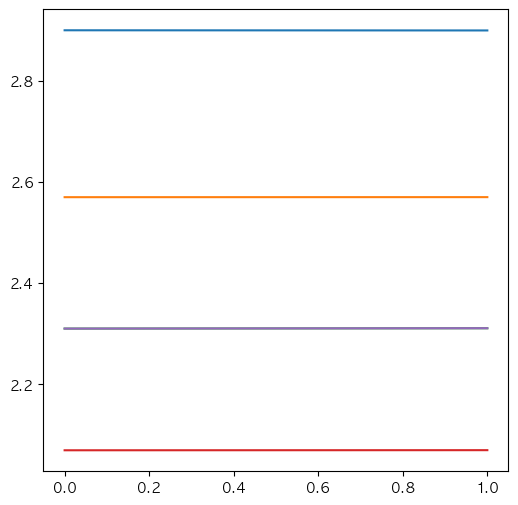

In [26]:
# PRQ
plt.figure(figsize=(6, 6))  # 그림의 크기 설정
temp = np.mean(target_sim.achv_population_PRQ, axis=1)

for i in range(temp.shape[1]):
    plt.plot(temp[:,i])
    
plt.legend(dict_target_idx_hospital.keys())  # 범례 추가
plt.grid(True)  # 그리드 표시
plt.ylim(0,5)
plt.show()  # 그래프 출력

In [27]:
# mean PHQ for each region
plt.figure(figsize=(6, 6))  # 그림의 크기 설정

for key in dict_target_idx_hospital:
    plt.plot((np.mean(np.mean(target_sim.achv_population_PHQ[:,:,dict_target_idx_hospital[key]], axis=1), axis=1)))
    
plt.legend(dict_target_idx_hospital.keys())  # 범례 추가
plt.grid(True)  # 그리드 표시
plt.ylim(1,4)
plt.show()  # 그래프 출력

NameError: name 'dict_target_idx_hospital' is not defined

<Figure size 600x600 with 0 Axes>

In [28]:
# mean OHQ for each region
plt.figure(figsize=(6, 6))  # 그림의 크기 설정

for key in dict_target_idx_hospital:
    plt.plot(np.mean(achv_OHQ[:,dict_target_idx_hospital[key]], axis=1))
    
plt.legend(dict_target_idx_hospital.keys())  # 범례 추가
plt.grid(True)  # 그리드 표시
plt.ylim(0,5)
plt.show()  # 그래프 출력

NameError: name 'dict_target_idx_hospital' is not defined

<Figure size 600x600 with 0 Axes>

  0%|          | 0/5 [00:00<?, ?it/s]

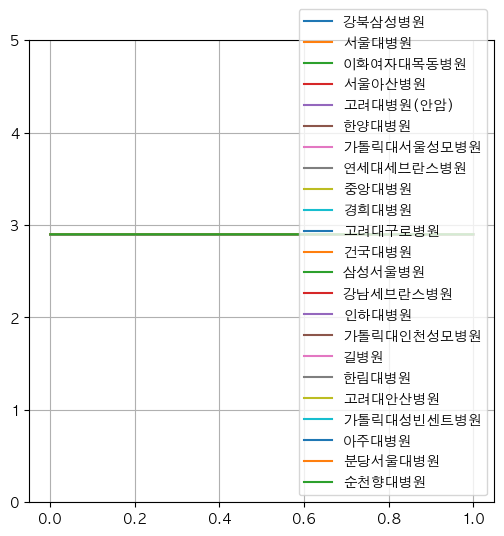

 20%|██        | 1/5 [00:00<00:00,  9.13it/s]

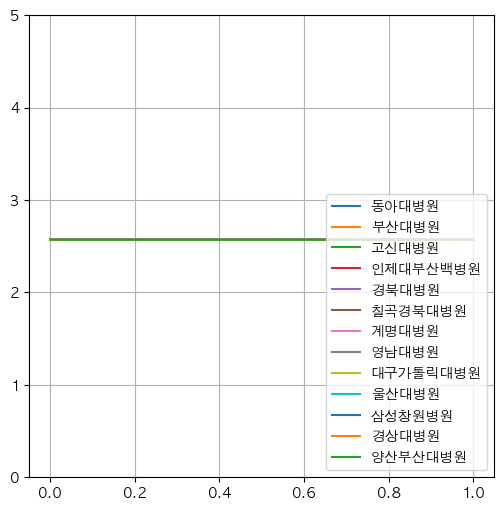

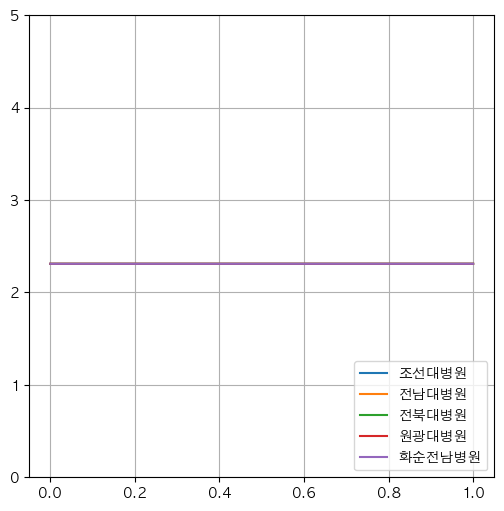

 60%|██████    | 3/5 [00:00<00:00, 12.63it/s]

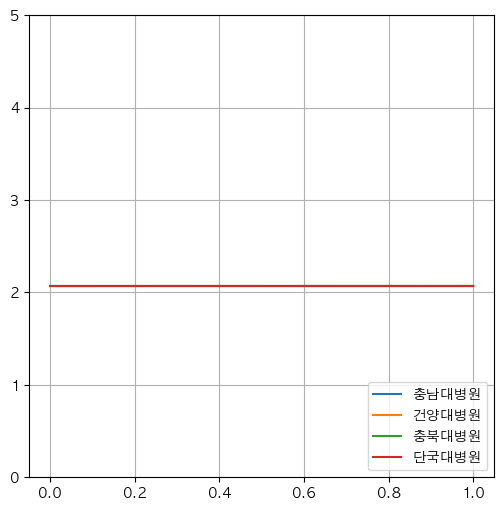

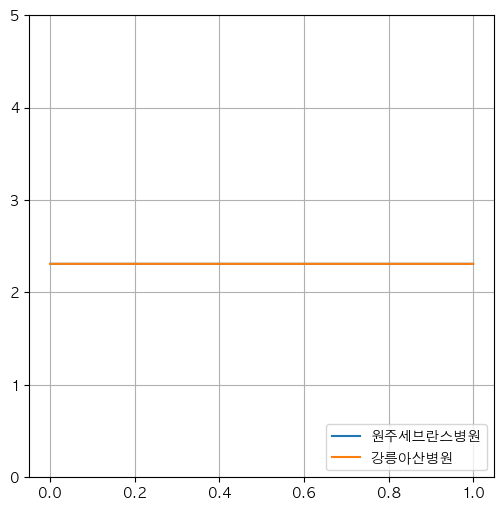

100%|██████████| 5/5 [00:00<00:00, 14.03it/s]


In [190]:
# PHQ in single region
for idx_region in tqdm(region_mapping.values()):
    nm_region = list(region_mapping.keys())[idx_region]
    list_idx_hospital = dict_target_idx_hospital[nm_region]

    plt.figure(figsize=(6, 6))  # 그림의 크기 설정

    for idx_hospital in list_idx_hospital:
        plt.plot(np.mean(target_sim.achv_population_PHQ, axis=1)[:,idx_hospital]
                ,label=target_sim.df_Hospital_info.loc[target_sim.df_Hospital_info.idx_hospital == idx_hospital, 'nm_hospital'].values[0]) 
        
    plt.legend(loc='lower right')  # 범례 추가
    plt.grid(True)  # 그리드 표시
    plt.ylim(0,5)

#     plt.savefig(str(date)+'_sim_'+str(num_sim)+'___'+
#             'PHQ_region_'+str(idx_region)+'.png')
    plt.show()  # 그래프 출력

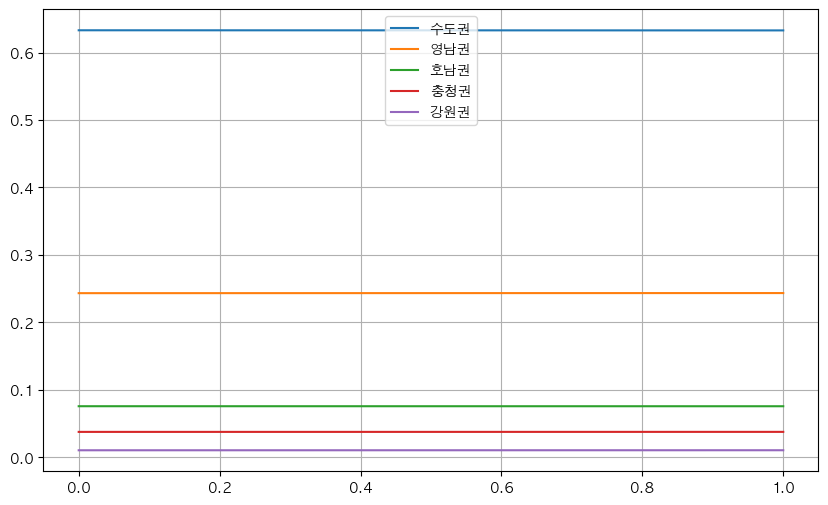

In [191]:
# Regional Choice Prob

plt.figure(figsize=(10, 6))  # 그림의 크기 설정

achv_choice_prob = np.mean(target_sim.achv_population_choice_prob, axis=1)

for idx_region in region_mapping.values():
    nm_region = list(region_mapping.keys())[idx_region]
    plt.plot(np.sum(achv_choice_prob[:,dict_target_idx_hospital[nm_region]], axis=1)
             , label=nm_region)  

plt.legend()  # 범례 추가
plt.grid(True)  # 그리드 표시
# plt.ylim(0,1.2)
plt.show()  # 그래프 출력